### 

`fastq-dump`

https://www.biostars.org/p/222122/


In [1]:
# !wget ftp.sra.ebi.ac.uk/vol1/fastq/SRR117/072/SRR11711272/SRR11711272_1.fastq.gz

In [2]:
# ls -lh GSE79044_RNAseq/fastq

In [3]:
# cat GSE79044_RNAseq/fastq/download.out

In [4]:
# srr = open('GSE79044_RNAseq/SRR_Acc_List.txt')

# for s in srr.readlines():
#     s = s.replace('\n','')
#     n = s[-1]
#     cmd=f'rsync -av rsync://ftp.sra.ebi.ac.uk/vol1/fastq/SRR321/00{n}/{s}/{s}.fastq.gz .'
#     print(cmd)

### 

In [5]:
import os
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob

from pydeseq2.preprocessing import deseq2_norm

In [6]:
import sys

In [9]:
sys.path.append('../scripts')

from util import find_top

In [10]:
import blitzgsea as blitz

import upsetplot as up

from matplotlib import pyplot as plt

In [11]:
import upsetplot as up

In [13]:
delta_exp = {
    "Macrophage": pd.read_csv(
        'exp/res_Macrophage_vs_HL_60_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    'Monocyte': pd.read_csv(
        'exp/res_Monocyte_vs_HL_60_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    "Neutrophil": pd.read_csv(
        'exp/res_Neutrophil_vs_HL_60_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    "decitabine+rg3039":pd.read_csv(
        '../DAC-rg3039/RNA-seq/exp/res_comb_vs_dmso_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    "decitabine":pd.read_csv(
        '../DAC-rg3039/RNA-seq/exp/res_decitabine_vs_dmso_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name']),
    "rg3039":pd.read_csv(
        '../DAC-rg3039/RNA-seq/exp/res_rg3039_vs_dmso_delta_exp_table.txt',sep='\t'
    ).set_index(['gene_id','gene_name'])
}

delta_exp_df = pd.concat(delta_exp,axis=1)

In [14]:
delta_exp_genes = {}

for delta_name in delta_exp.keys():
    print(f'\033[1m{delta_name}\033[0m')
    # delta_exp_genes[delta_name] = {}
    delta_exp_genes[f'{delta_name}_up'], delta_exp_genes[f'{delta_name}_down'] = [
        set(df.index.to_frame().gene_name.to_list()) for df in 
        find_top(delta_exp[delta_name],'log2FoldChange',1,'pvalue',0.05)
    ]

Macrophage
up:  3117
down: 3046
Monocyte
up:  1442
down: 1253
Neutrophil
up:  2571
down: 3221
decitabine+rg3039
up:  2156
down: 1487
decitabine
up:  1150
down: 265
rg3039
up:  1160
down: 820


In [76]:
data = up.from_contents(delta_exp_genes)

In [77]:
pager_annotation_path = '/data_gilbert/home/aarab/tools/pager/annotations/human'

In [78]:
c5_go_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt'
)

In [79]:
library = {}
# library = c5_go_gmt#{}

In [80]:
# library = {k:v for k,v in delta_exp_genes.items() if k 
#          not in [
#              t+'_'+s for t in ['decitabine+rg3039','decitabine','rg3039'] for s in ['up','down']
#          ]}

In [81]:
library['ol'] = set(
    up.query(data,
             present=['decitabine+rg3039_up','Macrophage_up','Monocyte_up','Neutrophil_up'],
             absent=['decitabine_up','rg3039_up']
            ).data['id'].to_list()
)

### 

In [82]:
# {k:v for (k,v) in delta_exp_genes.items() if 'up' in k}

In [83]:
gsea_results = {}

for treat in ['decitabine+rg3039','decitabine','rg3039']:

    signature = delta_exp[treat]['log2FoldChange'].reset_index('gene_name').reset_index(drop=True).fillna(0).copy()
    
    res = blitz.gsea(
        signature,
        library,
        verbose=True
    )
    
    gsea_results[treat] = res
    
    del res,signature

Use cached anchor parameters


Enrichment : 100%|██████████| 1/1 [00:00<00:00, 361.24it/s]


Use cached anchor parameters


Enrichment : 100%|██████████| 1/1 [00:00<00:00, 460.66it/s]


Use cached anchor parameters


Enrichment : 100%|██████████| 1/1 [00:00<00:00, 374.56it/s]

Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 3.2406641315741814e-06
KS p-value (neg): 3.2406641315741814e-06


In [84]:
figs = {}

for treat in ['decitabine+rg3039','decitabine','rg3039']:

    signature = delta_exp[treat]['log2FoldChange'].reset_index('gene_name').reset_index(drop=True).fillna(0).copy()
    
    res = gsea_results[treat]
    
    fig_table = blitz.plot.top_table(signature, library, res, n=1)

    figs[treat] = fig_table
    
    del res,signature

In [85]:
import pypage

In [86]:
# gs_ann = pypage.GeneSets(ann_file=, n_bins=3)

In [87]:
# def run_pyPAGE(expression, annotation):
    
#     p = pypage.PAGE(
#         expression,
#         annotation,
#         n_shuffle=1000,
#         k=7,
#         filter_redundant=True
#     )
#     results, hm = p.run()
#     hm.convert_from_to('gs', 'ensg', 'human')
#     hm.show(show_reg=True)
    
#     return results


In [88]:
import upsetplot as up

In [89]:
upset = up.UpSet(data, intersection_plot_elements=0)  # disable the default bar chart

In [90]:
# from matplotlib import cm

# upset.add_stacked_bars(
#     by="Sex", colors=cm.Pastel1, title="Count by gender", elements=10
# )

# upset.plot()
# plt.suptitle("Gender for first class and survival on Titanic")
# plt.show()


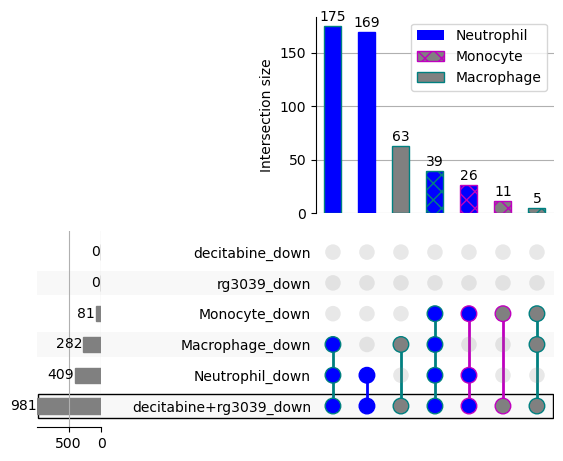

In [92]:
data_down = up.from_contents({k:v for (k,v) in delta_exp_genes.items() if 'down' in k})

result = up.query(data_down, 
                  present='decitabine+rg3039_down',
                  absent=['decitabine_down','rg3039_down']
                 )

upset = up.UpSet(
    result.data, 
    # data, 
    sort_by='cardinality',
    subset_size="count",
    # orientation=
    facecolor="gray",
    min_degree=2,
    show_counts=True,
    # max_degree=2
)

upset.style_subsets(present=['Neutrophil_down'],   min_degree=2, label="Neutrophil",facecolor="blue")
upset.style_subsets(present=['Monocyte_down'],     min_degree=2, label='Monocyte',hatch="xx", edgecolor="m")
upset.style_subsets(present=['Macrophage_down'],   min_degree=2, label='Macrophage',edgecolor="teal")

upset.style_categories("decitabine+rg3039_down", shading_edgecolor="black", shading_linewidth=1)

upset.plot()
plt.show()

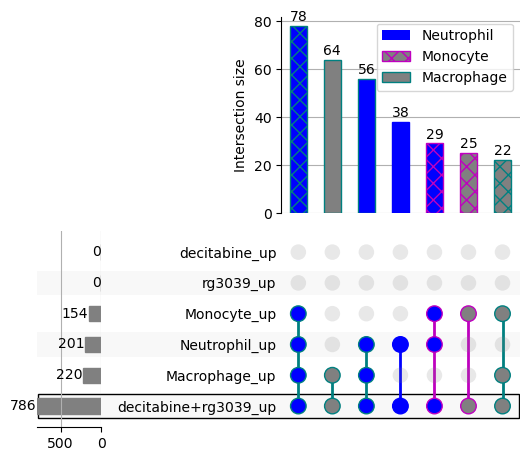

In [93]:
data_up = up.from_contents({k:v for (k,v) in delta_exp_genes.items() if 'up' in k})

result = up.query(data_up, 
                  present='decitabine+rg3039_up',
                  absent=['decitabine_up','rg3039_up']
                 )

upset = up.UpSet(
    result.data, 
    # data, 
    sort_by='cardinality',
    subset_size="count",
    # orientation=
    facecolor="gray",
    min_degree=2,
    show_counts=True,
    # max_degree=2
)

upset.style_subsets(present=['Neutrophil_up'],   min_degree=2, label="Neutrophil",facecolor="blue")
upset.style_subsets(present=['Monocyte_up'],     min_degree=2, label='Monocyte',hatch="xx", edgecolor="m")
upset.style_subsets(present=['Macrophage_up'],   min_degree=2, label='Macrophage',edgecolor="teal")

upset.style_categories("decitabine+rg3039_up", shading_edgecolor="black", shading_linewidth=1)

upset.plot()
plt.show()

In [99]:
ol_genesets = {}

for side in ['up','down']:
    ol_genesets[f'Neutrophil_{side}'] = list(set(up.query(
            data,
            present=[f'decitabine+rg3039_{side}',f'Neutrophil_{side}'],
            absent=[f'decitabine_{side}',f'rg3039_{side}',
                    f'Macrophage_{side}',f'Monocyte_{side}']
        ).data['id']))

    ol_genesets[f'Monocyte_{side}'] = list(set(up.query(
            data,
            present=[f'decitabine+rg3039_{side}',f'Monocyte_{side}'],
            absent=[f'decitabine_{side}',f'rg3039_{side}',
                    f'Macrophage_{side}',f'Neutrophil_{side}']
        ).data['id']))

    ol_genesets[f'Macrophage_{side}'] = list(set(up.query(
            data,
            present=[f'decitabine+rg3039_{side}',f'Macrophage_{side}'],
            absent=[f'decitabine_{side}',f'rg3039_{side}',
                    f'Monocyte_{side}',f'Neutrophil_{side}']
        ).data['id']))

In [100]:
for k,v in ol_genesets.items():
    pd.Series(v).to_csv(f'exp/geneset_{k}.txt',index=False,header=None)
    pd.Series(v).to_csv(f'../DAC-rg3039/RNA-seq/exp/geneset_{k}.txt',index=False,header=None)    

In [103]:
[(k, len(v))for k,v in ol_genesets.items()]

[('Neutrophil_up', 38),
 ('Monocyte_up', 25),
 ('Macrophage_up', 64),
 ('Neutrophil_down', 169),
 ('Monocyte_down', 11),
 ('Macrophage_down', 63)]

In [104]:
# RNA_seq_dir = 'exp'
RNA_seq_dir = '../DAC-rg3039/RNA-seq/exp'

# conditions = ['Macrophage_vs_HL_60','Monocyte_vs_HL_60','Neutrophil_vs_HL_60']
conditions = ['comb_vs_dmso','decitabine_vs_dmso','rg3039_vs_dmso']

# for geneset_name in [geneset_name]:#['Monocyte_up']:#ol_genesets.keys():
for geneset_name in ol_genesets.keys():

    for condition in conditions:
        pd.read_csv(
            f'{RNA_seq_dir}/res_{condition}_delta_exp.txt',sep='\t'
        ).drop_duplicates('gene_name').to_csv(f'{RNA_seq_dir}/res_{condition}_delta_exp.c.txt',sep='\t',index=False)

        print(condition,geneset_name)
        !bash ../scripts/onePAGE.sh \
            {RNA_seq_dir} \
            res_{condition}_delta_exp.c.txt \
            geneset_{geneset_name} &> /dev/null

comb_vs_dmso Neutrophil_up
decitabine_vs_dmso Neutrophil_up
rg3039_vs_dmso Neutrophil_up
comb_vs_dmso Monocyte_up
decitabine_vs_dmso Monocyte_up
rg3039_vs_dmso Monocyte_up
comb_vs_dmso Macrophage_up
decitabine_vs_dmso Macrophage_up
rg3039_vs_dmso Macrophage_up
comb_vs_dmso Neutrophil_down
decitabine_vs_dmso Neutrophil_down
rg3039_vs_dmso Neutrophil_down
comb_vs_dmso Monocyte_down
decitabine_vs_dmso Monocyte_down
rg3039_vs_dmso Monocyte_down
comb_vs_dmso Macrophage_down
decitabine_vs_dmso Macrophage_down
rg3039_vs_dmso Macrophage_down


In [121]:
sys.path.append('/data_gilbert/home/aarab/tools/pager/')

In [123]:
import onePAGE

In [126]:
from glob import glob

In [151]:
path = f'{RNA_seq_dir}/res_comb_vs_dmso_delta_exp.c_onePAGE_geneset_Macrophage_up/'

exp = 'res_comb_vs_dmso_delta_exp.c'

In [152]:
pd.read_csv(f'{path}/{exp}.txt.matrix',sep='\t')

,MOTIF,[-28.03 -0.52],[-0.52 0.00],[0.00 0.00],[0.00 0.00].1,[0.00 0.00].2,[0.00 0.87],[0.87 23.59]
0,0,-4.8903,-4.8903,-4.8903,-4.8903,-4.8903,-4.8903,61.8063


In [ ]:
matrix_list.append(pd.read_csv(f'{path}/{exp}.txt.matrix',sep='\t'))
summary_list.append(pd.read_csv(f'{path}/{exp}.txt.summary',sep='\t'))

In [135]:
def merge_onePAGE_results(path_list):
    path0 = path_list[0]
    
    pdir = '/'.join(path0.split('/')[:-1])
    exp = path0.split('/')[-1].split('_onePAGE_')[0]
    onePAGE = f'{pdir}/{exp}_onePAGE'
    if not os.path.exists(onePAGE): 
        os.mkdir(onePAGE)
    if not os.path.exists(f'{pdir}/{exp}_onePAGE/{exp}.txt'):
        os.rename(f'{path0}/{exp}.txt', f'{pdir}/{exp}_onePAGE/{exp}.txt')
    
    genesets = []
    matrix_list = []
    summary_list = []
    
    for path in path_list:
        geneset = path.split('/')[-1].split('_onePAGE_')[1]
        genesets.append(geneset)
        # read_onePAGE_matrices
        matrix_list.append(pd.read_csv(f'{path}/{exp}.txt.matrix',sep='\t'))
        summary_list.append(pd.read_csv(f'{path}/{exp}.txt.summary',sep='\t'))
    
    summary = pd.concat(summary_list)
    summary['index'] = genesets
    matrix  = pd.concat(matrix_list)
    matrix['MOTIF'] = genesets

    matrix.to_csv(f'{onePAGE}/{exp}.txt.matrix',sep='\t',header=True,index=False)
    summary.to_csv(f'{onePAGE}/{exp}.txt.summary',sep='\t',header=True,index=False)
    
    return matrix


FileNotFoundError: [Errno 2] No such file or directory: 'DAC-rg3039/RNA-seq/exp/res_decitabine_vs_dmso_delta_exp.c_onePAGE_geneset_Macrophage_up//.txt' -> 'DAC-rg3039/RNA-seq/exp/res_decitabine_vs_dmso_delta_exp.c_onePAGE_geneset_Macrophage_up/_onePAGE/.txt'

In [107]:
# RNA_seq_dir = 'DAC-rg3039/RNA-seq/exp'

# geneset_name = 'GOBP_POSITIVE_REGULATION_OF_MYELOID_CELL_DIFFERENTIATION'

# conditions = ['comb_vs_dmso','decitabine_vs_dmso','rg3039_vs_dmso']

# for condition in conditions:
#     pd.read_csv(
#         f'{RNA_seq_dir}/res_{condition}_delta_exp.txt',sep='\t'
#     ).drop_duplicates('gene_name').to_csv(f'{RNA_seq_dir}/res_{condition}_delta_exp.c.txt',sep='\t',index=False)

        # !bash scripts/onePAGE.sh \
        #     {RNA_seq_dir} \
        #     res_{condition}_delta_exp.c.txt \
        #     geneset_{geneset_name} &> /dev/null

In [106]:
# pd.Series(list(set(up.query(
#     data,
#     present=['decitabine+rg3039_up','Macrophage_up','Monocyte_up','Neutrophil_up'],
#     absent=['decitabine_up','rg3039_up']
# ).data['id']))).to_csv('DAC-rg3039/RNA-seq/exp/geneset.txt',index=False,header=None)

# pd.Series(list(set(up.query(
#     data,
#     present=['decitabine+rg3039_up','Macrophage_up','Monocyte_up','Neutrophil_up'],
#     absent=['decitabine_up','rg3039_up']
# ).data['id']))).to_list()

___

In [109]:
# for geneset_name,geneset in delta_exp_genes.items():
#     pd.Series(list(set(geneset))).to_csv(
#         f'DAC-rg3039/RNA-seq/exp/geneset_{geneset_name}.txt',index=False,header=None
#     )

#     for treatment in ['comb_vs_dmso','decitabine_vs_dmso','rg3039_vs_dmso']:
#         pd.read_csv(
#             f'DAC-rg3039/RNA-seq/exp/res_{treatment}_delta_exp.txt',sep='\t'
#         ).drop_duplicates('gene_name').to_csv(f'DAC-rg3039/RNA-seq/exp/res_{treatment}_delta_exp.c.txt',sep='\t',index=False)

#         !bash scripts/onePAGE.sh \
#             DAC-rg3039/RNA-seq/exp/ \
#             res_{treatment}_delta_exp.c.txt \
#             geneset_{geneset_name} &> /dev/null

In [187]:
# data = from_contents({k:v for (k,v) in delta_exp_genes.items() if 'down' in k})
# data[data.reset_index().set_index('id')[
#     ['Macrophage_down','Monocyte_down','Neutrophil_down','decitabine+rg3039_down']
# ].all(axis=1).to_list()]['id'].to_list()

In [499]:
# cnt = pd.read_csv('GSE79044_RNAseq/exp/deseq2_raw_counts.txt',sep='\t')

# meta = pd.read_csv("GSE79044_RNAseq/SraRunTable.txt").set_index('Run').loc[
#     :,['source_name','Time']
# ].loc[cnt.columns[2:].to_list()]

# # cnt = pd.concat(dict([
# #     (
# #         os.path.basename(file).split('_')[0],
# #         pd.read_csv(file,sep='\t').set_index('gene_id').iloc[:,0]
# #     )
# #     for file in glob('GSE79044_RNAseq/processed/*')
# # ]),axis=1)
# # cnt.index.name = None



# adata = ad.AnnData(
#     X=cnt.set_index(['gene_id']).drop(columns='gene_name').T,
#     obs=meta,
#     var=cnt.set_index(['gene_id'])[['gene_name']]
# )

# cnt_DAC_rg3039 = pd.read_csv(
#     'DAC-rg3039/RNA-seq/deseq2_raw_counts.txt',
#     sep='\t'
# ).set_index('gene_id')

# ann = cnt_DAC_rg3039[['gene_name']]
# cnt_DAC_rg3039 = cnt_DAC_rg3039.drop(columns='gene_name')

# ol = list(
#     set(cnt_DAC_rg3039.index) & set(adata.var.index)
# )

# bdata = ad.AnnData(
#     X=cnt_DAC_rg3039.T,
#     # obs=
#     var=ann
# )

# from venn import venn

# venn(
#     {
#         'Ramirez_et_al':set(adata.var.index),
#         'bioRxiv':set(cnt_DAC_rg3039.index)
#     }
# )

# mdata = ad.concat([adata, bdata])
# sc.pp.filter_genes(mdata,min_counts=50)

# mdata.X = np.log1p(deseq2_norm(mdata.X)[0])

# mdata.shape

In [500]:
# adata_filt = adata[adata.obs.query('Time in ["0 hr","120 hr"]').index].copy()

# sc.pp.pca(adata_filt)
# sc.pp.neighbors(adata_filt)

In [175]:
# sc.tl.umap(adata_filt,alpha=.9)
# # sc.tl.leiden(mdata)

# sc.pl.pca(adata_filt,size=100,color='source_name')
# sc.pl.pca(adata_filt,size=100,color='Time')

In [134]:
mdata.obs['source'] = ''

mdata.obs.loc[mdata.obs.index.str.contains('SRR'),'source'] = 'Ramirez_et_al'
mdata.obs.loc[~mdata.obs.index.str.contains('SRR'),'source'] = 'bioRxiv'

In [135]:
sc.pp.pca(mdata)
sc.pp.neighbors(mdata)

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


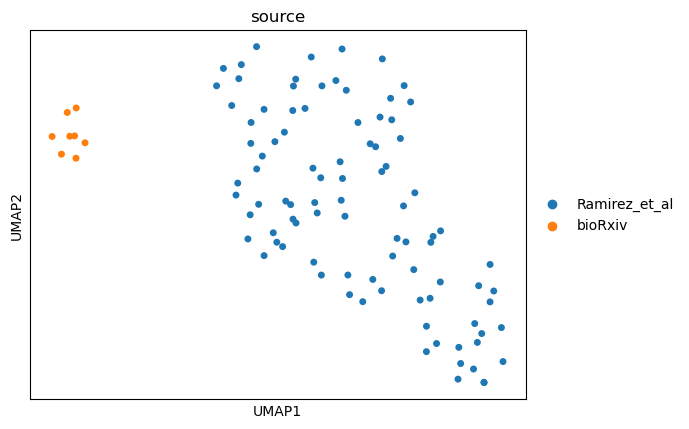

In [136]:
sc.tl.umap(mdata,alpha=.9)
# sc.tl.leiden(mdata)

sc.pl.umap(mdata,size=100,color='source')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/pydeseq2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


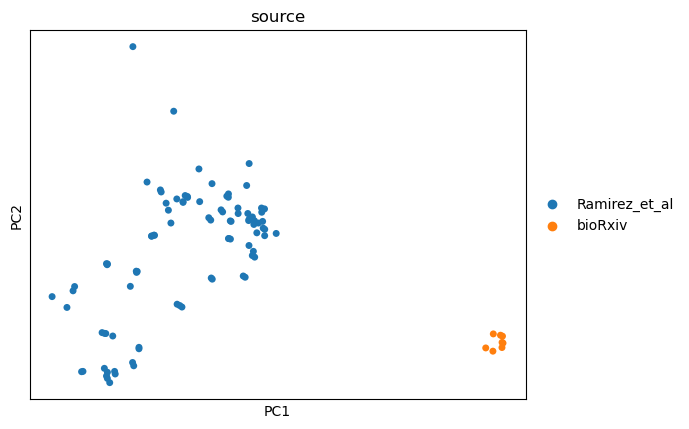

In [137]:
sc.pl.pca(mdata,size=100,color='source')

### 

In [101]:
adata = ad.AnnData(
    X=counts.T
)

adata.obs = pd.DataFrame(adata.obs.index.str.split('_R').to_list(),columns=['group', 'replicate'],index=adata.obs.index)
# adata.X = deseq2_norm(np.log1p(adata.X))[0]

In [102]:
adata

AnnData object with n_obs × n_vars = 17 × 4570
    obs: 'group', 'replicate'

In [103]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

In [104]:
sc.tl.umap(adata)

In [105]:
sc.tl.leiden(adata)

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


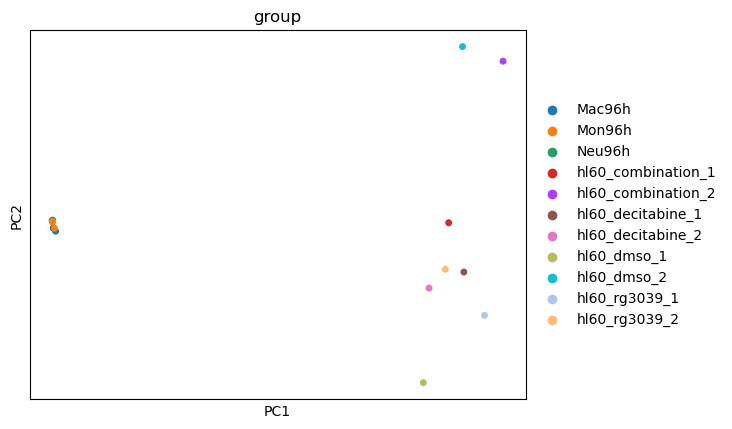

In [106]:
sc.pl.pca(adata,size=100,color='group')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


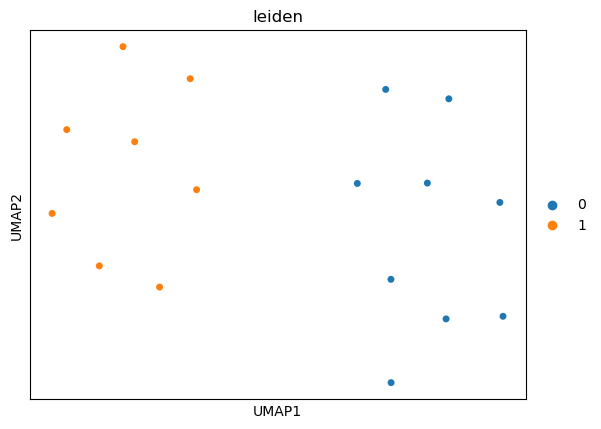

In [71]:
sc.pl.umap(adata,size=100,color='leiden')

# 

In [ ]:
%load_ext watermark

In [ ]:
%watermark

Last updated: 2024-02-20T00:18:56.720394-08:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [ ]:
%watermark --iversions

matplotlib: 3.8.0
sys       : 3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) 
[GCC 12.3.0]
numpy     : 1.26.0
pandas    : 2.1.1
seaborn   : 0.12.2

